In [45]:
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from tqdm import tqdm
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss,accuracy_score, confusion_matrix, f1_score
import plotly.express as px


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [46]:
reviews = pd.read_csv('https://raw.githubusercontent.com/swapnilsethi/Machine-Learning-and-Neural-Network/main/ML%20Project/olist_order_reviews_dataset.csv')


In [47]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [48]:
reviews.shape

(99224, 7)

In [49]:
reviews['review_comment_message'].isna().sum()

58247

In [50]:
def clean_data(data,
               points_cut = [0, 2, 5], 
               classes = [0, 1]):
    
    df_bin = data
    df_bin = df_bin.dropna(subset=["review_comment_message"])
    df_bin['label'] = pd.cut(df_bin["review_score"], bins=points_cut, labels=classes)
    df_bin = df_bin[['review_comment_message','label']]
    return df_bin


data_bin  = clean_data(reviews)

In [51]:
data_bin = data_bin[0:10000]

In [52]:
data_bin.tail(10)

,review_comment_message,label
23913,Somente o Quadro Cofre Para minha Próxima Viag...,0
23918,Entregou no prazo porém muito demorado.,1
23922,A melhor loja entrega rápida recomendo a todos,1
23923,ok,0
23924,"FOI ENTREGUE ANTES DO PRAZO,GOSTEI!!!!",1
23929,Eu recomendo!,1
23930,"Muito bom, super recomendo 😍",1
23931,"tudo dentro da normalidade de venda, compra e ...",1
23932,"Produto entregue em mãos,lindo e original.Desa...",1
23933,Linda e confortável essa cadeira...,1


In [53]:
data_bin.shape

(10000, 2)

In [54]:
fig = px.bar(x = np.unique(data_bin["label"]), 
             y = [list(data_bin["label"]).count(i) for i in np.unique(data_bin["label"])] , 
             color=np.unique(data_bin["label"]) ,
             color_continuous_scale="Emrld")  
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [55]:
def process_data(texts):
    
    processed_text = []
    
    portuguese_stopwords = stopwords.words('portuguese') # portugese language stopwords
    stemmer = RSLPStemmer() # portugese language stemmer
    
    links = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' # check for hyperlinks
    dates = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}' # check for dates
    currency = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+' # check for currency symbols
    
    for text in tqdm(texts):
        text = re.sub('[\n\r]', ' ', text) # remove new lines
        text = re.sub(links, ' URL ', text) # remove hyperlinks
        text = re.sub(dates, ' ', text) # remove dates
        text = re.sub(currency, ' dinheiro ', text) # remove currency symbols
        text = re.sub('[0-9]+', ' numero ', text) # remove digits
        text = re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text) # replace no with negative
        text = re.sub('\W', ' ', text) # remove extra whitespaces
        text = re.sub('\s+', ' ', text) # remove extra spaces
        text = re.sub('[ \t]+$', '', text) # remove tabs etc.
        text = ' '.join(e for e in text.split() if e.lower() not in portuguese_stopwords) # remove stopwords
#         text = ' '.join(stemmer.stem(e.lower()) for e in text.split()) # stemming the words
        processed_text.append(text.lower().strip())
        
    return processed_text

In [56]:
processed_text = process_data(data_bin['review_comment_message'])

100%|██████████| 10000/10000 [00:00<00:00, 19871.18it/s]


In [57]:
data_bin['review_comment_message'] = processed_text

In [58]:
data_bin.tail(10)

,review_comment_message,label
23913,somente quadro cofre próxima viagem numero x n...,0
23918,entregou prazo porém demorado,1
23922,melhor loja entrega rápida recomendo todos,1
23923,ok,0
23924,entregue antes prazo gostei,1
23929,recomendo,1
23930,bom super recomendo,1
23931,tudo dentro normalidade venda compra entrega,1
23932,produto entregue mãos lindo original desagrado...,1
23933,linda confortável cadeira,1


In [59]:
X = data_bin['review_comment_message']
y = data_bin['label']

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=25)

In [61]:
#from sklearn.datasets import make_classification
#X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)
X_train = X_train.to_numpy()
X_train= X_train.reshape(-1, 1)
print(X_train.shape)

(8000, 1)


In [62]:
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)
print(y_train.shape)

(8000, 1)


In [63]:
#random upsampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_train, y_train = oversample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_train))

Counter({1: 5865, 0: 5865})


In [64]:
print("Train data: ",X_train.shape,y_train.shape)
print("Test data: ",X_test.shape,y_test.shape)

Train data:  (11730, 1) (11730,)
Test data:  (2000,) (2000,)


In [65]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [66]:
X_train =X_train.rename(columns={0: "review_comment_message"})
X_test =X_test.rename(columns={0: "review_comment_message"})

In [67]:
X_test.head()

,review_comment_message
5517,recomendo loja conta correios atraso entrega
22998,fiquei satisfeito entrega lannister
19793,produto chegou antes prazo bom estado bem emba...
1285,boa tarde problemas pedido sim veio mosqueteir...
4796,carrinho bonito


In [68]:
X_train['review_comment_message']

0                        gostei chegou bem antes pra prazo
1                              talvez dificuldade correios
2        comprei numero produtos recebi numero aguardan...
3           produto igual foto amei pedido super recomendo
4            chegou produto bem antes prazo estipulado bom
                               ...                        
11725     aguardando instalação produto loja especializada
11726           falta entregue suporte pés chegou vasilhas
11727    produto ainda negação entregue comprei mês ain...
11728                      momento negação recebir produto
11729    mandaram numero produtos embalagens separadas ...
Name: review_comment_message, Length: 11730, dtype: object

 ## Encoding categorical feature review_comment_message

In [69]:

# # Word2vec encoding
# # https://radimrehurek.com/gensim/models/word2vec.html
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

path = get_tmpfile("word2vec.model")

texts = [x.split(' ') for x in data_bin['review_comment_message']]

w2vmodel = Word2Vec(texts, size=300, window=5, min_count=1, workers=4)
w2vmodel.save("word2vec.model")

w2vmodel = Word2Vec.load("word2vec.model")
w2vmodel.train(texts, total_examples=len(texts), epochs=10)


(547854, 746510)

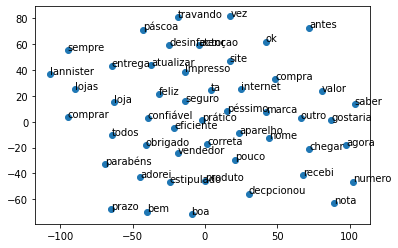

In [70]:

words =  list(w2vmodel.wv.vocab.keys())
vectors = [w2vmodel.wv[word] for word in words]

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

Y = tsne.fit_transform(vectors[:50])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()


In [71]:
# http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc#
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f.readlines()[1:]):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], "float32")#np.array([float(0) if val=='0,0' else float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

embeddings = loadGloveModel('drive/MyDrive/glove_s300.txt')

Loading Glove Model


100%|██████████| 929605/929605 [00:38<00:00, 23853.55it/s]


Done. 929605  words loaded!


In [72]:
def tfidfWord2Vector(text,glove_words,tfidf_words,tf_values):
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(text): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = w2vmodel.wv[word] # embeddings[word] 
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = tf_values[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    tfidf_w2v_vectors = np.asarray(tfidf_w2v_vectors)
    
    return tfidf_w2v_vectors

In [73]:
# encoding review comment message using Tfidf weighted W2V
tfidf = TfidfVectorizer()
tfidf.fit(X_train['review_comment_message'])
# pickle.dump(tfidf,open('tfidf_review_comments.pkl','wb'))

# we are converting a dictionary with word as a key, and the idf as a value
tf_values = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())
glove_words = list(w2vmodel.wv.vocab.keys()) # list(embeddings.keys())

tfidf_w2v_vectors_train = tfidfWord2Vector(X_train['review_comment_message'].values,glove_words,tfidf_words,tf_values)
tfidf_w2v_vectors_test = tfidfWord2Vector(X_test['review_comment_message'].values,glove_words,tfidf_words,tf_values)

100%|██████████| 2000/2000 [00:00<00:00, 6018.18it/s]


In [74]:
tfidf_w2v_vectors_train.shape

(11730, 300)

In [75]:
tfidf_w2v_vectors_train

array([[-0.09278105,  0.25390897, -0.02376211, ...,  0.12494949,
        -0.19431565,  0.42467959],
       [ 0.16821829,  0.08489781, -0.09552192, ...,  0.19372288,
        -0.10260402,  0.19632318],
       [ 0.09788445,  0.33855052, -0.00776782, ...,  0.7565428 ,
        -0.53946571,  0.50032246],
       ...,
       [-0.04140095,  0.36560118, -0.06971086, ...,  0.62219855,
        -0.48610409,  0.39368342],
       [ 0.02186173,  0.21782954, -0.05044237, ...,  0.31716479,
        -0.1966711 ,  0.20078635],
       [ 0.07589103,  0.14952092, -0.04542763, ...,  0.15518107,
        -0.11347718,  0.20208918]])

In [76]:
'''
from google.colab import files

X_train = pd.DataFrame(tfidf_w2v_vectors_train)
X_test = pd.DataFrame(tfidf_w2v_vectors_test)

X_train.to_csv('X_train.csv')
files.download('X_train.csv')

y_train.to_csv('y_train.csv')
files.download('y_train.csv')

X_test.to_csv('X_test.csv')
files.download('X_test.csv')

y_test.to_csv('y_test.csv')
files.download('y_test.csv')
'''

"\nfrom google.colab import files\n\nX_train = pd.DataFrame(tfidf_w2v_vectors_train)\nX_test = pd.DataFrame(tfidf_w2v_vectors_test)\n\nX_train.to_csv('X_train.csv')\nfiles.download('X_train.csv')\n\ny_train.to_csv('y_train.csv')\nfiles.download('y_train.csv')\n\nX_test.to_csv('X_test.csv')\nfiles.download('X_test.csv')\n\ny_test.to_csv('y_test.csv')\nfiles.download('y_test.csv')\n"

## Decision Tree

Depth =  3 Train Score 0.8494464944649447 test Score 0.8729861371300113
Depth =  10 Train Score 0.9311363839885377 test Score 0.889689978370584
Depth =  50 Train Score 0.9959135024689255 test Score 0.8762746430999319
Depth =  100 Train Score 0.9959135024689255 test Score 0.8762746430999319
Depth =  250 Train Score 0.9959135024689255 test Score 0.8762746430999319
Depth =  500 Train Score 0.9959135024689255 test Score 0.8762746430999319


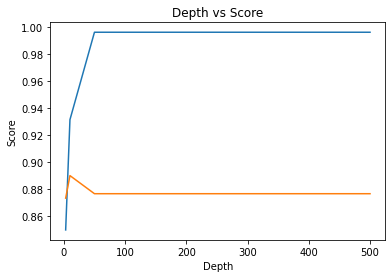

In [77]:
# Checking the variation of score with depth parameters of Decision Tree
depth = [3,10,50,100,250,500]
train_scores = []
test_scores = []
for i in depth:
    clf = DecisionTreeClassifier(max_depth=i,random_state=25)
    clf.fit(tfidf_w2v_vectors_train,y_train)
    train_sc = f1_score(y_train,clf.predict(tfidf_w2v_vectors_train))
    test_sc = f1_score(y_test,clf.predict(tfidf_w2v_vectors_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth = ',i,'Train Score',train_sc,'test Score',test_sc)

# plotting the score vs depth
plt.plot(depth,train_scores,label='Train Score')
plt.plot(depth,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs Score')
plt.show()

In [78]:
# Parameter tuning of DecisionTreeClassifier using RandomisedSearch CV technique
# https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
dt = DecisionTreeClassifier(random_state=25)

params = { "max_depth": sp_randint(3,500), "min_samples_split": sp_randint(50,200), "min_samples_leaf": sp_randint(2,50)}

random_cfl1 = RandomizedSearchCV(dt, param_distributions=params,verbose=10,scoring='f1',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(tfidf_w2v_vectors_train,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
mean test scores [0.85804419 0.86052645 0.85911221 0.8562354  0.85956378 0.86006071
 0.86655456 0.85866695 0.85836958 0.85749516]
mean train scores [0.87511419 0.87708454 0.89156252 0.87601798 0.89354747 0.89387068
 0.91868963 0.88443831 0.8806671  0.88013727]


In [79]:
# printing best parameters and scores
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'max_depth': 304, 'min_samples_leaf': 5, 'min_samples_split': 51}
Best Score:  0.8665545568968167


In [80]:
# Fitting the model on best parameters
dt = DecisionTreeClassifier(max_depth = 320, min_samples_leaf = 25, min_samples_split = 186,random_state=25)
dt.fit(tfidf_w2v_vectors_train,y_train)

y_train_pred = dt.predict(tfidf_w2v_vectors_train)
y_test_pred = dt.predict(tfidf_w2v_vectors_test)

# printing train test score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))
from sklearn.metrics import accuracy_score
print('Accuracy is',accuracy_score(y_test,y_test_pred))


Train f1 score 0.8775163281739287
Test f1 score 0.8820512820512819
Accuracy is 0.839


In [81]:
def confusion_matrices_plot(y_real, y_pred, y_test,y_test_pred):
    # representing confusion matric in heatmap format
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cmap=sns.light_palette("brown")
    C1 = confusion_matrix(y_real,y_pred)
    C2 = confusion_matrix(y_test,y_test_pred)
    
    fig,ax = plt.subplots(1, 2, figsize=(15,5))
    ax1 = sns.heatmap(C1, annot=True, cmap=cmap, fmt=".2f", ax = ax[0])
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Original Class')
    ax1.set_title("Train Confusion matrix")

    ax2 = sns.heatmap(C2, annot=True, cmap=cmap, fmt=".2f", ax = ax[1])
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Original Class')
    ax2.set_title("Test Confusion matrix")
    
    plt.show()

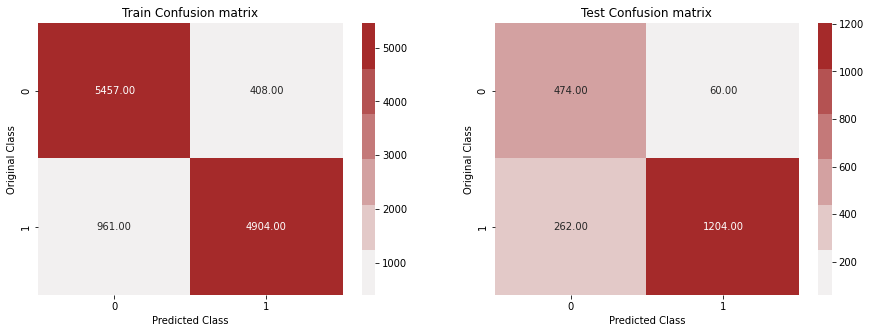

In [82]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

## SVM

In [83]:
from sklearn.svm import SVC

Kernel =  linear Train Score 0.8505999816799488 test Score 0.8813432835820896
Kernel =  rbf Train Score 0.8587724063009233 test Score 0.883772744151504
Kernel =  poly Train Score 0.7976401179941004 test Score 0.8412883197516492
Kernel =  sigmoid Train Score 0.7120499444111862 test Score 0.7829341317365269


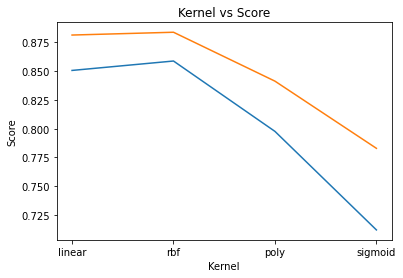

In [84]:
# Checking the variation of score with depth parameters of Decision Tree
kernels = ['linear','rbf','poly','sigmoid']
train_scores = []
test_scores = []
for i in kernels:
    clf = SVC(C=1,random_state=25, kernel= i)
    clf.fit(tfidf_w2v_vectors_train,y_train)
    train_sc = f1_score(y_train,clf.predict(tfidf_w2v_vectors_train))
    test_sc = f1_score(y_test,clf.predict(tfidf_w2v_vectors_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Kernel = ',i,'Train Score',train_sc,'test Score',test_sc)

# plotting the score vs depth
plt.plot(kernels,train_scores,label='Train Score')
plt.plot(kernels,test_scores,label='Test Score')
plt.xlabel('Kernel')
plt.ylabel('Score')
plt.title('Kernel vs Score')
plt.show()

Combination is linear 1
Train f1 score 0.8505999816799488
Test f1 score 0.8813432835820896
Accuracy is 0.841


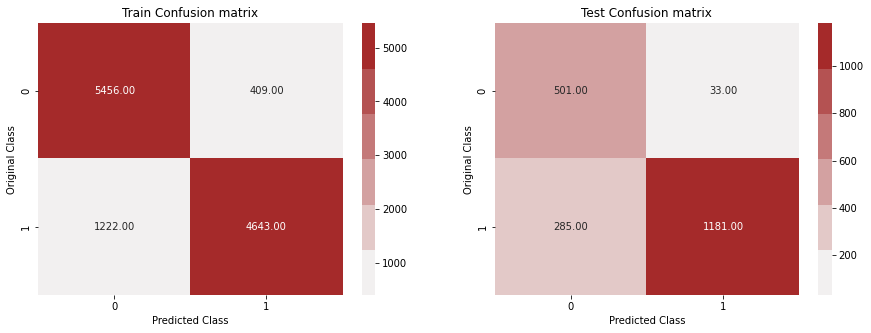

Combination is linear 10
Train f1 score 0.8592742678209615
Test f1 score 0.8828358208955224
Accuracy is 0.843


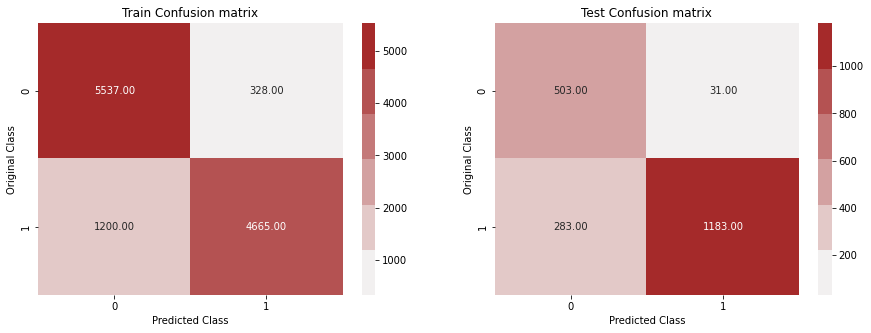

Combination is linear 25
Train f1 score 0.8616236162361623
Test f1 score 0.88382517743743
Accuracy is 0.8445


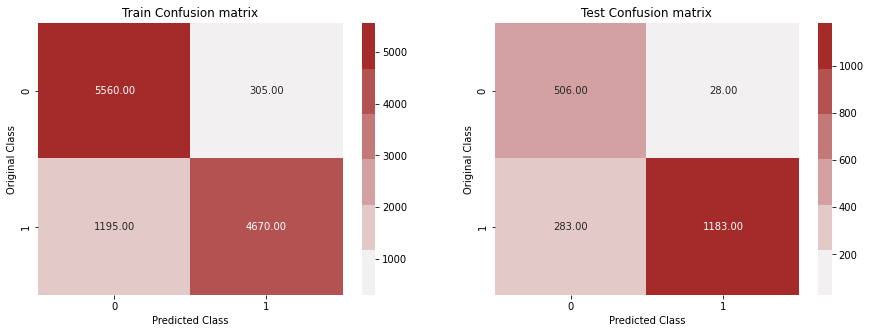

Combination is linear 50
Train f1 score 0.862415797729999
Test f1 score 0.8849028400597907
Accuracy is 0.846


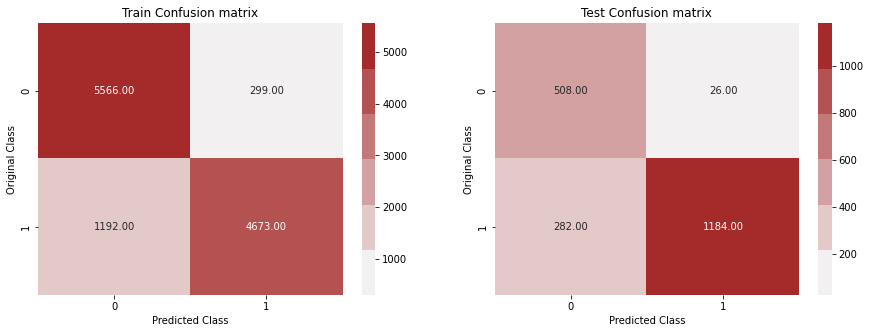

Combination is rbf 1
Train f1 score 0.8587724063009233
Test f1 score 0.883772744151504
Accuracy is 0.8435


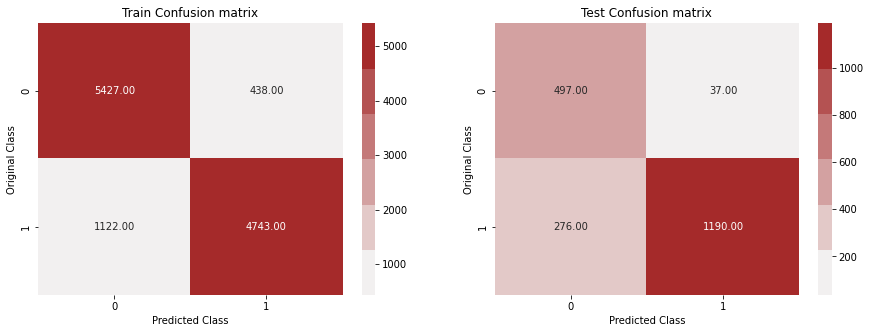

Combination is rbf 10
Train f1 score 0.8702898550724638
Test f1 score 0.8895456224602881
Accuracy is 0.8505


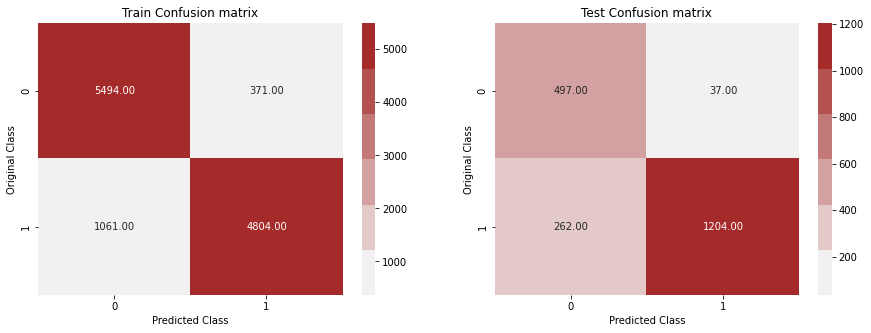

Combination is rbf 25
Train f1 score 0.8737529475784509
Test f1 score 0.8901220865704772
Accuracy is 0.8515


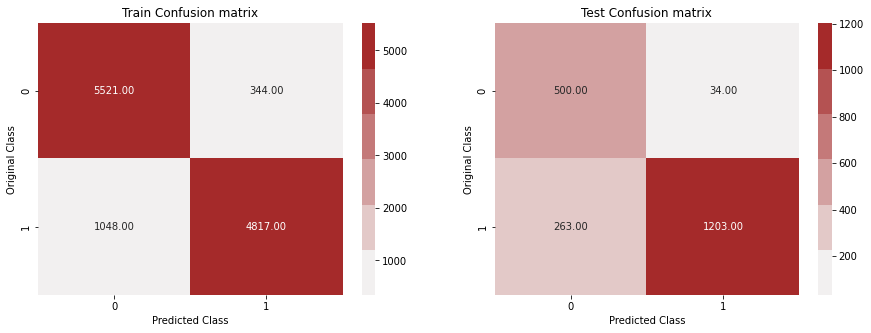

Combination is rbf 50
Train f1 score 0.8785928007978965
Test f1 score 0.8923303834808259
Accuracy is 0.854


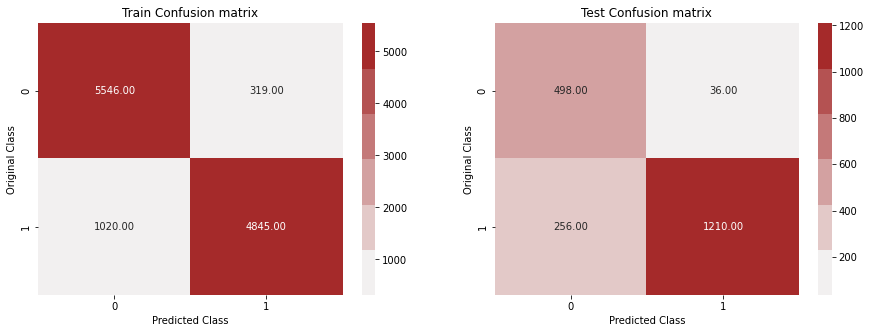

Combination is poly 1
Train f1 score 0.7976401179941004
Test f1 score 0.8412883197516492
Accuracy is 0.7955


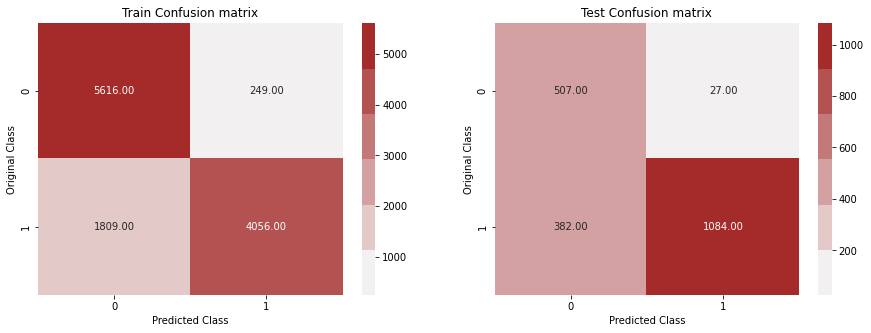

Combination is poly 10
Train f1 score 0.8230318177448813
Test f1 score 0.8639636225843123
Accuracy is 0.8205


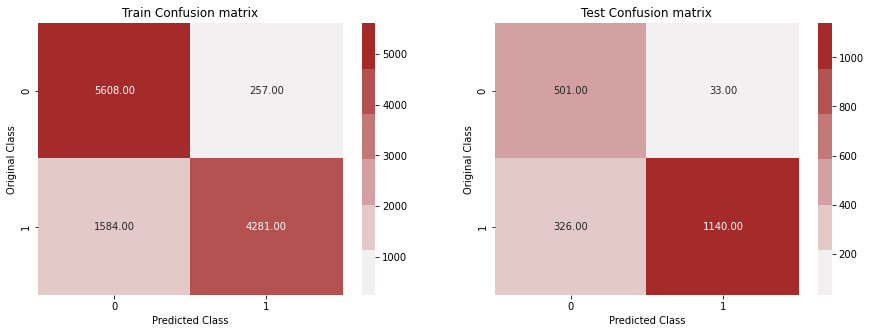

Combination is poly 25
Train f1 score 0.830633566567622
Test f1 score 0.869762174405436
Accuracy is 0.8275


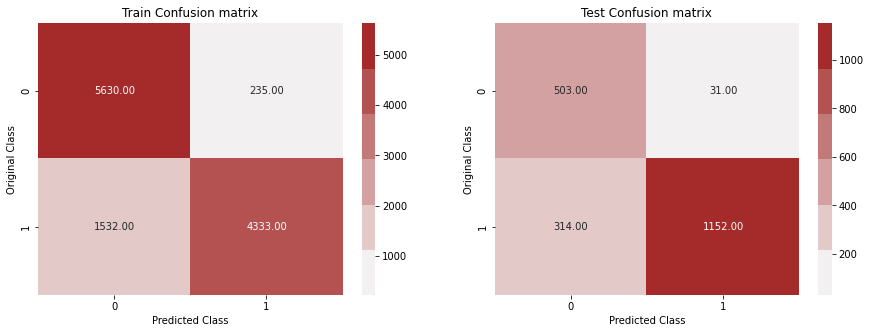

Combination is poly 50
Train f1 score 0.8363740567389435
Test f1 score 0.8731652239367709
Accuracy is 0.8315


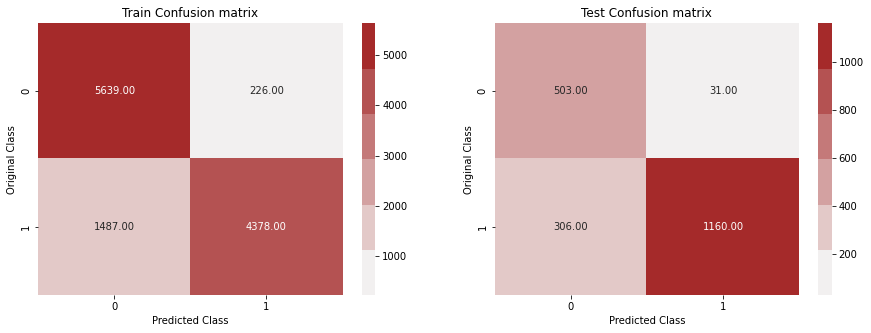

Combination is sigmoid 1
Train f1 score 0.7120499444111862
Test f1 score 0.7829341317365269
Accuracy is 0.71


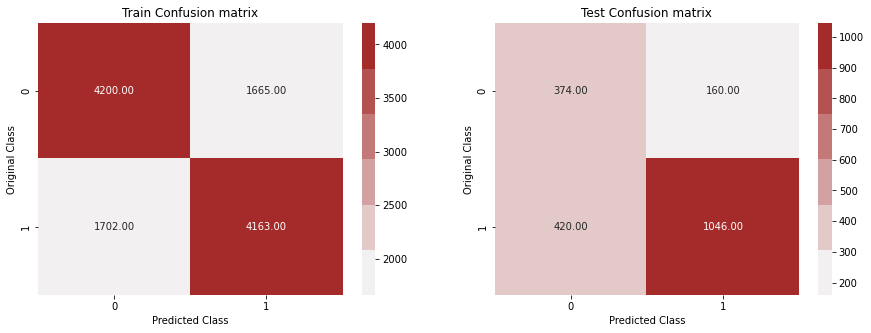

Combination is sigmoid 10
Train f1 score 0.7104589660467496
Test f1 score 0.7844602166604407
Accuracy is 0.7115


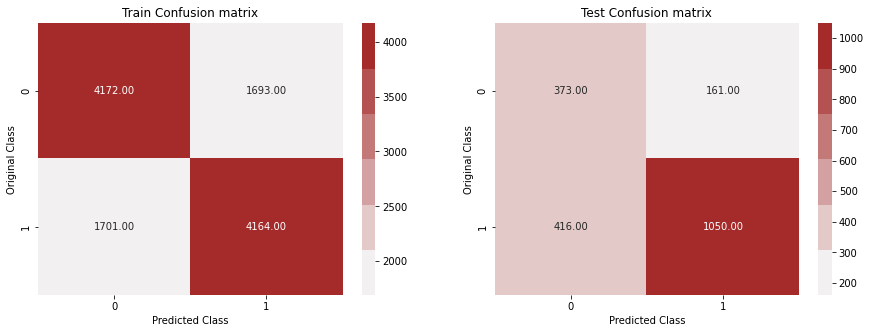

Combination is sigmoid 25
Train f1 score 0.7105689669879725
Test f1 score 0.7844602166604407
Accuracy is 0.7115


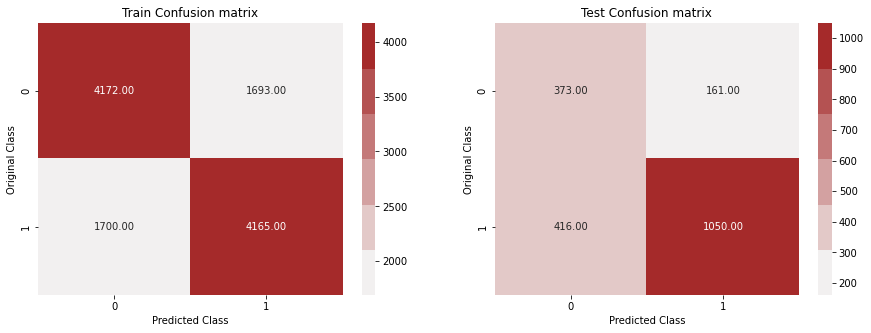

Combination is sigmoid 50
Train f1 score 0.7105689669879725
Test f1 score 0.784167289021658
Accuracy is 0.711


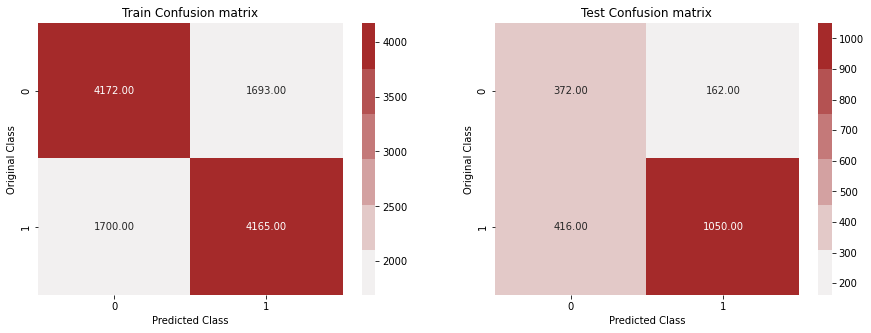

In [85]:
# Fitting the model on best kernel
from sklearn.metrics import accuracy_score
kernels = ['linear','rbf','poly','sigmoid']
Cost = [1,10,25,50]
for i in kernels:
    for j in Cost:
        SV = SVC(C=j,random_state=25, kernel= i)
        SV.fit(tfidf_w2v_vectors_train,y_train)

        y_train_pred = SV.predict(tfidf_w2v_vectors_train)
        y_test_pred = SV.predict(tfidf_w2v_vectors_test)

        # printing train test score
        print('Combination is' , i , j )
        print('Train f1 score',f1_score(y_train,y_train_pred))
        print('Test f1 score',f1_score(y_test,y_test_pred))
        print('Accuracy is',accuracy_score(y_test,y_test_pred))
        confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

## Naive Bayes

In [86]:
from sklearn.naive_bayes import GaussianNB

In [87]:
# Fitting the model on best kernel
NB = GaussianNB()
NB.fit(tfidf_w2v_vectors_train,y_train)

y_train_pred = NB.predict(tfidf_w2v_vectors_train)
y_test_pred = NB.predict(tfidf_w2v_vectors_test)

# printing train test score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))
print('Accuracy is',accuracy_score(y_test,y_test_pred))

Train f1 score 0.8203783480052443
Test f1 score 0.8524714828897337
Accuracy is 0.806


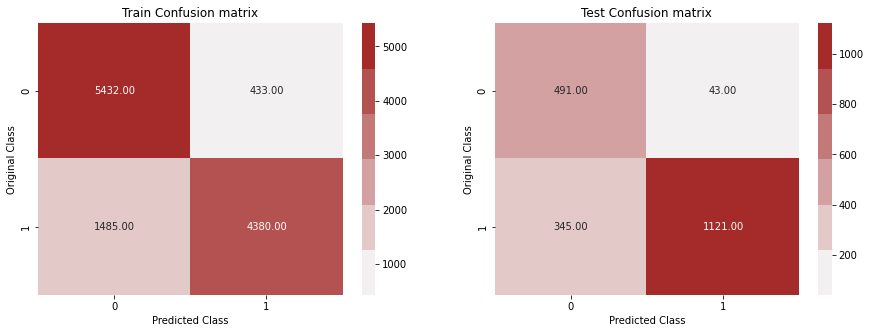

In [88]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

In [89]:
tfidf_w2v_vectors_train

array([[-0.09278105,  0.25390897, -0.02376211, ...,  0.12494949,
        -0.19431565,  0.42467959],
       [ 0.16821829,  0.08489781, -0.09552192, ...,  0.19372288,
        -0.10260402,  0.19632318],
       [ 0.09788445,  0.33855052, -0.00776782, ...,  0.7565428 ,
        -0.53946571,  0.50032246],
       ...,
       [-0.04140095,  0.36560118, -0.06971086, ...,  0.62219855,
        -0.48610409,  0.39368342],
       [ 0.02186173,  0.21782954, -0.05044237, ...,  0.31716479,
        -0.1966711 ,  0.20078635],
       [ 0.07589103,  0.14952092, -0.04542763, ...,  0.15518107,
        -0.11347718,  0.20208918]])

## NN

In [90]:
y_train = np.array(y_train)

In [91]:
# number of input vectors
train_size = tfidf_w2v_vectors_train.shape[0] 
print('\n train_size is:\n',train_size)

# number of columns in the input vector
c = tfidf_w2v_vectors_train.shape[1]
print('\n Number of columns in input vector:\n',c)

#number of neuron in hidden layer 1
h = 10

#Number of outputs
o = 1



 train_size is:
 11730

 Number of columns in input vector:
 300


In [92]:
# Define learning rate
LR=0.0001
LRB = 0.001

In [93]:
class NeuralNetwork(object):
    def __init__(self):

        self.InputNumColumns = tfidf_w2v_vectors_train.shape[1]
        print('Number of Input columns are (c):',self.InputNumColumns)

        self.HiddenUnitsInHidenLayer1 = 300
        print('Hidden Units in Hidden Layer 1 are (H1):',self.HiddenUnitsInHidenLayer1)

        self.HiddenUnitsInHidenLayer2 = 150
        print('Hidden Units in Hidden Layer 2 are (H2):',self.HiddenUnitsInHidenLayer2)

        self.OutputUnits= 1
        print('Outputs are (O):',self.OutputUnits)



        self.W1 = np.random.randn(self.InputNumColumns, self.HiddenUnitsInHidenLayer1) # c by h1  
        print('\nW1 is:\n', self.W1)

        self.B1 = np.random.randn(1,self.HiddenUnitsInHidenLayer1) # h1 by 1
        print('\nB1 is:\n', self.B1)

        self.W2 = np.random.randn(self.HiddenUnitsInHidenLayer1,self.HiddenUnitsInHidenLayer2) # h1 by h2
        print('\nW2 is:\n', self.W2)

        self.B2 = np.random.randn(1,self.HiddenUnitsInHidenLayer2) # h2 by 1
        print('\nB2 is:\n', self.B2)

        self.W3 = np.random.randn(self.HiddenUnitsInHidenLayer2,self.OutputUnits) # h1 by h2
        print('\nW3 is:\n', self.W3)

        self.C  = np.random.randn(1,self.OutputUnits,) # C by 1
        print('\nC is:\n', self.C)
    


    ## Activation Function
    def sigmoid(self, S, deriv = False):
        if(deriv == True):
            return np.multiply(S,(1 - S))
        return 1/(1 + np.exp(-S))



    def FeedForward(self, X):

        print("FeedForward\n\n")
        self.Z1 = (np.dot(X, self.W1)) + self.B1
        print("\nZ1 is:\n", self.Z1)
        
        self.H1 = self.sigmoid(self.Z1) 
        print("\nH1 is:\n", self.H1)
        
        self.Z2 = (np.dot(self.H1, self.W2)) + self.B2 
        print("\nZ2 is:\n", self.Z2)
        
        self.H2 = self.sigmoid(self.Z2) 
        print("\nH2 is:\n", self.H2)

        self.Z3 = (np.dot(self.H2, self.W3)) + self.C 
        print("\nZ3 is:\n", self.Z3)

        output = self.sigmoid(self.Z3)  

        print("\noutput Y^ is:\n", output)
        return output

    
    def BackProp(self, X, Y, output):
        print("\n\nBackProp\n")
        self.LR = LR
        self.LRB= LRB  ## LR for biases
        
        # Y^ - Y
        self.output_error = output - Y    
        print("Y^ - Y\n", self.output_error)
        
        #(Y^-Y)*(Y^)(1-Y^)

        #print('\nY^(1-Y^) is:\n', self.sigmoid(output, deriv=True))
        self.output_delta = np.multiply(self.output_error , self.sigmoid(output, deriv=True))
        print('output_delta')
          
        ##(Y^ - Y)*(Y^)(1-Y^)*(W3)
        self.D_Error_W3 = self.output_delta.dot(self.W3.T) #  D_Error times W3
        print('D_Error_W3')
        #print("W3 is\n", self.W3)
        
        ## (Y^ - Y)*(Y^)(1-Y^)*(W3)*(H2)(1 - H2)
        self.H2_D_Error_W3 = np.multiply(self.D_Error_W3 , self.sigmoid(self.H2, deriv=True) )

        ##(Y^ - Y)*(Y^)(1-Y^)*(W3)*(H2)(1 - H2)*(W2)
        self.D_Error_W2 = self.H2_D_Error_W3.dot(self.W2.T) #  D_Error times W2
        #print("W2 is\n", self.W3)
        
        ## (Y^ - Y)*(Y^)(1-Y^)*(W3)*(H2)(1 - H2)*(W2)*(H1)(1-H1)
        self.H1_D_Error_W2 = np.multiply( self.D_Error_W2 , self.sigmoid(self.H1, deriv=True) )
        
        ################------UPDATE weights and biases of hidden layer------------------

        ##  (Y^ - Y)*(Y^)(1-Y^)*(W3)*(H2)(1-H2)*(W2)*(H1)(1-H1)(X)
        self.X_H1_D_Error_W2 = X.T.dot(self.H1_D_Error_W2) ## this is dW1
        
        ##  (Y^ - Y)*(Y^)(1-Y^)*(W3)*(H2)(1-H2)*(H1)
        self.H1_H2_D_Error_W3 = self.H1.T.dot(self.H2_D_Error_W3) ## this is dW2
        
        ## (Y^-Y)*(Y)(1-Y^)(H2) 
        self.H2_output_delta = self.H2.T.dot(self.output_delta) ## this is for dW3
        
        #print("the gradient :\n", self.X_H_D_Error_W2)
        #print("the gradient average:\n", self.X_H_D_Error_W2/self.n)
        
        print("Using sum gradient........\n")
        self.W1 = self.W1 - self.LR*(self.X_H1_D_Error_W2) # c by h  adjusting first set (input -> hidden) weights
        self.W2 = self.W2 - self.LR*(self.H1_H2_D_Error_W3) 
        self.W3 = self.W3 - self.LR*(self.H2_output_delta) 
        
        
        print("\nThe sum of the B2 update is\n", np.sum(self.H2_D_Error_W3, axis=0))
        print("\nThe B2 biases before the update are:\n", self.B2)
        self.B2 = self.B2  - self.LRB*np.sum(self.H2_D_Error_W3, axis=0)
        #print("The H_D_Error_W2 is...\n", self.H_D_Error_W2)
        print("\nUpdated B2 is:\n", self.B2)

        print("\nThe sum of the B1 update is\n", np.sum(self.H1_D_Error_W2, axis=0))
        print("\nThe B1 biases before the update are:\n", self.B1)
        self.B1 = self.B1  - self.LRB*np.sum(self.H1_D_Error_W2, axis=0)
        #print("The H_D_Error_W2 is...\n", self.H_D_Error_W2)
        print("\nUpdated B1 is:\n", self.B1)
        
        self.C = self.C - self.LR*np.sum(self.output_delta, axis=0)
        print("\nUpdated C's are:\n", self.C)
        
        print("\nThe W1 is: \n", self.W1)
        print("\nThe W1 gradient is: \n", self.X_H1_D_Error_W2)
        #print("The W1 gradient average is: \n", self.X_H1_D_Error_W2/self.n)
        print("\nThe W2 gradient  is: \n", self.H1_H2_D_Error_W3)
        #print("The W2 gradient average is: \n", self.H1_H2_D_Error_W3/self.n)
        print("\nThe W3 gradient  is: \n", self.H2_output_delta)
        #print("The W3 gradient average is: \n", self.H2_output_delta/self.n)
        print("\nThe biases B1 gradient is:\n",np.sum(self.H1_D_Error_W2, axis=0 ))
        print("\nThe biases B2 gradient is:\n",np.sum(self.H2_D_Error_W3, axis=0 ))
        print("\nThe bias C gradient is: \n", np.sum(self.output_delta, axis=0))




    def TrainNetwork(self, X, Y):
        output = self.FeedForward(X)
        print("\nOutput in TNN\n", output)
        self.BackProp(X, Y, output)
        return output

    def TestNetwork(self, X,Y):
        output = self.FeedForward(X)
        print("\nOutput in TestNN\n", output)
        return output

In [94]:
MyNN = NeuralNetwork()

TotalLoss=[]
AvgLoss=[]
Epochs=200

Number of Input columns are (c): 300
Hidden Units in Hidden Layer 1 are (H1): 300
Hidden Units in Hidden Layer 2 are (H2): 150
Outputs are (O): 1

W1 is:
 [[ 0.57223285  0.05850471 -0.17186788 ...  0.92817306  0.44972364
  -0.63134805]
 [ 0.02333456  1.47369471 -0.86984873 ... -1.02872391 -0.74117088
  -0.58088183]
 [ 0.62367861 -0.3160956  -1.76275547 ...  0.10728822 -0.66055382
  -1.76128311]
 ...
 [ 1.03599994 -1.17816138 -1.07686711 ...  1.76759862  1.01072153
  -0.3118497 ]
 [-0.42600852 -0.78061097 -0.9716799  ... -1.71713772 -0.04244065
  -1.00443911]
 [-0.26142284 -1.32267715  0.32936247 ...  1.01335098 -1.65375446
   1.29009807]]

B1 is:
 [[-5.58745448e-01 -1.26126536e+00 -7.98665368e-01 -3.65034132e-01
  -1.83569958e-01  2.35438220e+00 -1.30010302e+00  5.79574036e-01
  -5.33274165e-01  3.13379109e-01  5.44576434e-01 -4.31847887e-01
   6.54221663e-01  1.07827038e-01  2.64658906e-01 -9.05869777e-01
  -1.26005670e+00 -1.06291461e-01  1.43778120e+00  1.47284044e-01
  -2.35344466e

In [95]:
y_train

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [96]:
for i in range(Epochs): 
    print("\nRUN:\n ", i)
    output=MyNN.TrainNetwork(tfidf_w2v_vectors_train, y_train)
   
    #print("The y^ is ...\n", y^)
    print("\nThe output is: \n", output)
    print('\nActual Y is:\n',tfidf_w2v_vectors_train)
    ## Using Root Mean Squre...........
    loss = .5*(np.sum(np.square(output-y_train))) 
    print("\nThe current Total loss is\n", loss)
    TotalLoss.append(loss)
    #AvgLoss.append(loss)

Streaming output truncated to the last 5000 lines.

The W1 is: 
 [[ 0.57098823  0.05763409 -0.1756819  ...  0.9269827   0.4500336
  -0.63386123]
 [ 0.02411932  1.47389324 -0.8706093  ... -1.03255483 -0.74106958
  -0.57549991]
 [ 0.62285901 -0.31596008 -1.7626803  ...  0.10806966 -0.6605766
  -1.76473179]
 ...
 [ 1.03748564 -1.17866879 -1.07842162 ...  1.76698012  1.01115341
  -0.30835402]
 [-0.42785021 -0.7807666  -0.97211593 ... -1.71596326 -0.04265727
  -1.00726689]
 [-0.2581955  -1.32260159  0.33070526 ...  1.01137615 -1.65372357
   1.29731442]]

The W1 gradient is: 
 [[ 0.41305586  0.09547175  0.29850286 ...  0.27771121 -0.00363
   0.58362217]
 [-0.43531608 -0.16752842  1.20584028 ...  2.25928655  0.04121561
   1.01201834]
 [-0.18666728  0.0060127  -0.35827419 ... -0.80779551 -0.01196568
  -0.4693438 ]
 ...
 [-0.53681134 -0.11489942  0.85082513 ...  1.96886922 -0.00333489
   0.8612095 ]
 [ 0.64288979  0.16513535 -0.74273724 ... -1.8612258  -0.00997629
  -0.73571556]
 [-0.60971693 -

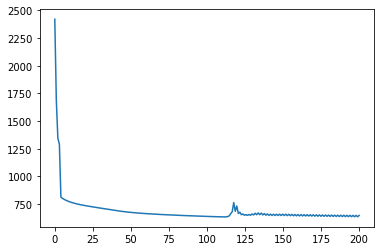

In [97]:
#print("Total Loss List:", TotalLoss) 
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax = plt.axes()
x = np.linspace(0, 200, Epochs)
ax.plot(x, TotalLoss)   

In [98]:
print("\nPredications:\n ")
output=MyNN.TestNetwork(tfidf_w2v_vectors_test, y_test)
#print("The y is ...\n", y)
print("\nThe output is: \n", output)
MaxValueIndex=np.argmax(output, axis=1)
print('Prediction y^ is', MaxValueIndex)


Predications:
 
FeedForward



Z1 is:
 [[ 2.34322637 -5.94924854  1.86462446 ...  1.12688161 11.87671537
   0.69828121]
 [ 3.70662234 -5.32282165  0.55427578 ...  2.22086715 13.18528245
   1.63246812]
 [ 3.34434735 -2.72393354 -7.13788849 ... -3.78874151  6.86666355
   5.36786187]
 ...
 [ 0.93152872 -4.91518283  0.37328303 ... -0.72298688  8.91001974
   1.37297307]
 [ 3.37471326 -3.16046714 -6.61798618 ... -4.95881394  5.87872566
   5.16451612]
 [ 2.42241112 -4.56797657 -2.48989054 ... -2.53689912  6.7410344
   1.33515827]]

H1 is:
 [[9.12394315e-01 2.60101650e-03 8.65835056e-01 ... 7.55262951e-01
  9.99993050e-01 6.67806585e-01]
 [9.76028411e-01 4.85527881e-03 6.35127036e-01 ... 9.02107800e-01
  9.99998122e-01 8.36507465e-01]
 [9.65919244e-01 6.15757772e-02 7.93797155e-04 ... 2.21235321e-02
  9.98959137e-01 9.95357560e-01]
 ...
 [7.17385326e-01 7.28097540e-03 5.92252035e-01 ... 3.26735592e-01
  9.99864989e-01 7.97860073e-01]
 [9.66904847e-01 4.06808193e-02 1.33433611e-03 ... 6.972296

In [99]:
output_test =[]
for i in (output):
    if(i < 0.50):
        output_test.append(0)
    else:
        output_test.append(1)

In [100]:
output_test = np. array(output_test).transpose()

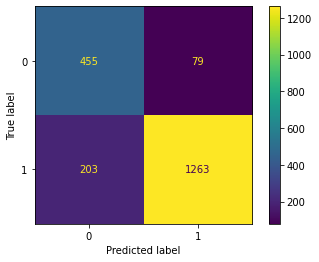

In [101]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, output_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, output_test)))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test, output_test, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, output_test, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, output_test, average='weighted')))


Accuracy: 0.86
Weighted Precision: 0.87
Weighted Recall: 0.86
Weighted F1-score: 0.86
